In [79]:
from random import seed
from random import randrange
from random import random
from csv import reader
from math import exp
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
# Initialize a network
def initialize_network(n_inputs, n_hidden, n_outputs):
    network = list()
    hidden_layer = [{'weights':[random() for i in range(n_inputs + 1)]} for i in range(n_hidden)]
    network.append(hidden_layer)
    output_layer = [{'weights':[random() for i in range(n_hidden + 1)]} for i in range(n_outputs)]
    network.append(output_layer)
    print(len(network))
    return network

In [81]:
# activation = sum(weight_i * input_i) + bias

# Calculate neuron activation for an input
def activate(weights, inputs):
    activation = weights[-1]
    for i in range(len(weights)-1):
        activation += weights[i] * inputs[i]
    return activation

In [82]:
# output = 1 / (1 + e^(-activation))
# Transfer neuron activation
def transfer(activation):
    return 1.0 / (1.0 + exp(-activation))

In [83]:
# Forward propagate input to a network output
# Прямое распространение ввода на сетевой выход
def forward_propagate(network, row):
    inputs = row
    for layer in network:
        new_inputs = []
        for neuron in layer:
            activation = activate(neuron['weights'], inputs)
            neuron['output'] = transfer(activation)
            new_inputs.append(neuron['output'])
        inputs = new_inputs
    return inputs

In [84]:
# derivative = output * (1.0 - output)
# Calculate the derivative of an neuron output
def transfer_derivative(output):
    return output * (1.0 - output)

In [85]:
# Считаем ошибку для каждого выходного нейрона (output)
# error = (expected - output) * transfer_derivative(output)

# Для скрытого слоя (hidden)
# error = (weight_k * error_j) * transfer_derivative(output)

# error_j - это сигнал ошибки от j- го нейрона в выходном слое
# weight_k - это вес, который соединяет k- й нейрон с текущим нейроном
# output - выход для текущего нейрона.

# Backpropagate error and store in neurons
def backward_propagate_error(network, expected):
    for i in reversed(range(len(network))):
        layer = network[i]
        errors = list()
        if i != len(network)-1:
            for j in range(len(layer)):
                error = 0.0
                for neuron in network[i + 1]:
                    error += (neuron['weights'][j] * neuron['delta'])
                errors.append(error)
        else:
            for j in range(len(layer)):
                neuron = layer[j]
                errors.append(expected[j] - neuron['output'])
        for j in range(len(layer)):
            neuron = layer[j]
            neuron['delta'] = errors[j] * transfer_derivative(neuron['output'])

In [86]:
# Обновление массы весов с помощью полученных ошибок
# weight = weight + learning_rate * error * input
# Update network weights with error
def update_weights(network, row, l_rate):
    for i in range(len(network)):
        inputs = row[:-1]
        if i != 0:
            inputs = [neuron['output'] for neuron in network[i - 1]]
        for neuron in network[i]:
            for j in range(len(inputs)):
                neuron['weights'][j] += l_rate * neuron['delta'] * inputs[j]
            neuron['weights'][-1] += l_rate * neuron['delta']

In [87]:
# Train a network for a fixed number of epochs
def train_network(network, train, l_rate, n_epoch, n_outputs):
    epoch_=[]
    sum_error_=[]
    for epoch in range(n_epoch):
        sum_error = 0
        for row in train:
            outputs = forward_propagate(network, row)
            expected = [0 for i in range(n_outputs)]
            expected[row[-1]] = 1
            sum_error += sum([(expected[i]-outputs[i])**2 for i in range(len(expected))])
            backward_propagate_error(network, expected)
            update_weights(network, row, l_rate)
        epoch_.append(epoch)
        sum_error_.append(sum_error)
#         print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    plt.figure(figsize=(20,10))
    plt.plot(epoch_,sum_error_,'go')


In [88]:
# Make a prediction with a network
def predict(network, row):
    outputs = forward_propagate(network, row)
    return outputs.index(max(outputs))

In [89]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            row=row[0]
            row = row.replace('\t', ',')
            row.split(',')
            dataset.append(row)
    return dataset

In [90]:
# Convert string column to float
def str_column_to_float(row):
    row = [float(row) for row in row.split(',')]
#     row[-1] = int(row[-1])
    return row

In [91]:
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]]
    return lookup

In [92]:
# Find the min and max values for each column
def dataset_minmax(dataset):
    minmax = list()
    stats = [[min(column), max(column)] for column in zip(*dataset)]
    return stats

In [93]:
# Rescale dataset columns to the range 0-1
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)-1):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])

In [94]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [95]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [96]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [97]:
# Backpropagation Algorithm With Stochastic Gradient Descent
def back_propagation(train, test, l_rate, n_epoch, n_hidden):
    n_inputs = len(train[0]) - 1
    n_outputs = len(set([row[-1] for row in train]))
    network = initialize_network(n_inputs, n_hidden, n_outputs)
    train_network(network, train, l_rate, n_epoch, n_outputs)
    predictions = list()
    for row in test:
        prediction = predict(network, row)
        predictions.append(prediction)
    return(predictions)

<class 'int'>
2
2
Scores: [80.0, 85.71428571428571]
Mean Accuracy: 82.857%


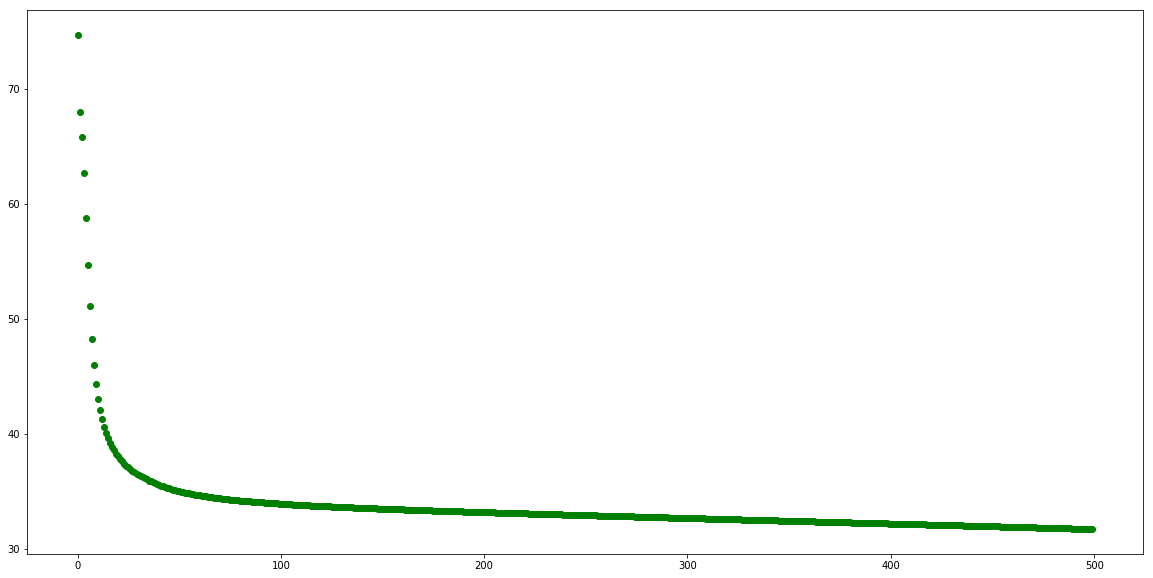

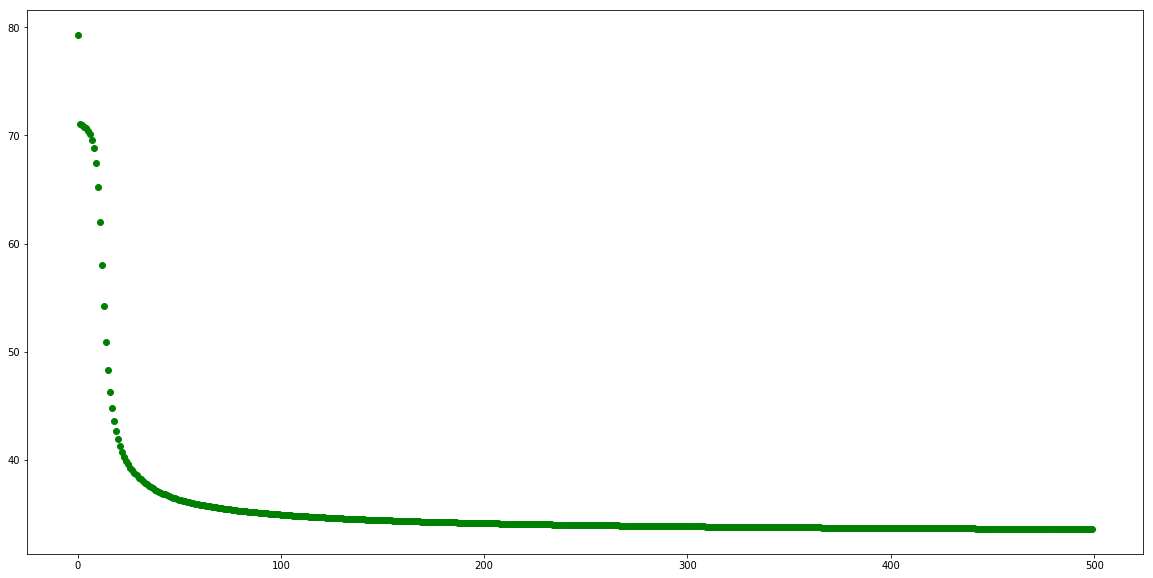

In [106]:
seed(1)
filename='seeds_dataset_1.csv'
dataset=load_csv(filename)
for i, row in enumerate(dataset):
    dataset[i]=str_column_to_float(row)
str_column_to_int(dataset, len(dataset[0])-1)
minmax = dataset_minmax(dataset)
normalize_dataset(dataset, minmax)
n_folds = 2
l_rate = 0.3
n_epoch = 500
n_hidden = 1
print(type(n_hidden))
scores = evaluate_algorithm(dataset,back_propagation, n_folds, l_rate, n_epoch, n_hidden)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))